#Homework 8


For this homework, we will be exploring a gene expression dataset profiling T cells derived from thymic and peripheral blood sources, as described in the study [GSE139242](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139242) and the accompanying paper [PMID: 32393182](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-020-6755-1).


### Prep
Start by Installing and Importing the necessary packages. Note that we will need to set some specific settings to get everything to run properly in Colaboratory.




In [ ]:
#!pip install networkx   # a powerful python library for building and analyzing networks
#!pip install ipycytoscape # this allows us to communicate with the Cytoscape app (we will install this stand alone app separately, the link is provided below)

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import scipy
from scipy import stats
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import seaborn as sns
import csv
import os
import sys
import argparse
from time import time
import random

import altair as alt
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import collections

#from google.colab import output
#output.enable_custom_widget_manager()

import ipycytoscape
import networkx as nx

In [2]:
random.seed(10)

pd.set_option('display.precision', 2)
pd.set_option('display.max_columns',10)

alt.data_transformers.disable_max_rows()

# We're also going to tell Jupyter to use inline plotting instead of notebook plotting
# It basically means you don't have to use plt.show() in every cell
%matplotlib inline

# and this command will allow multiple outputs from the same cell, rather than just the last one run
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Prepping the data
![HW8_FetchByIDwindow.png](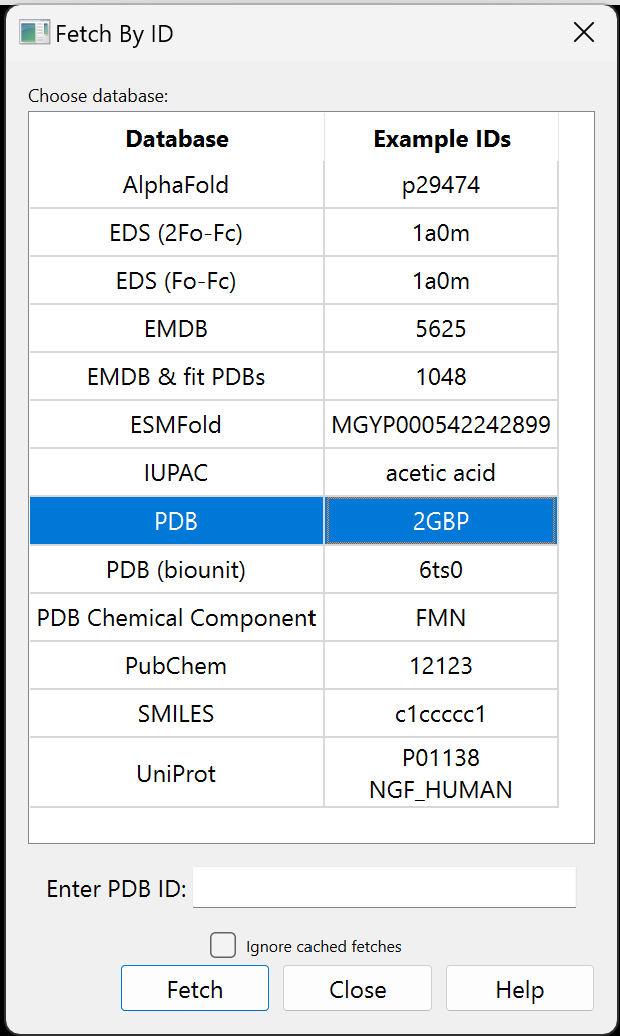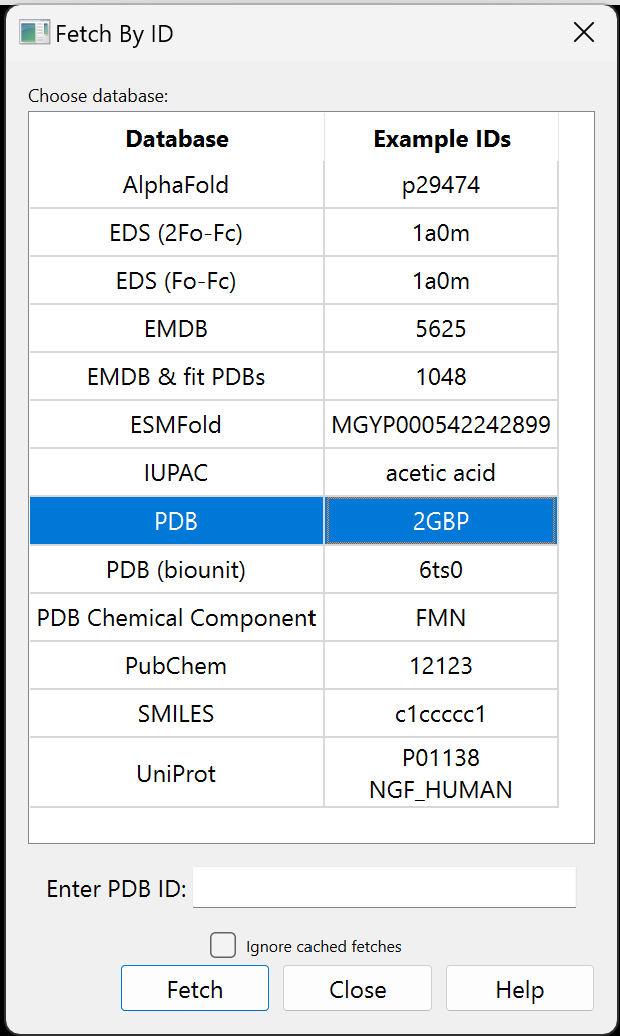)
You don't need to run this code block for the homework, as the datasets generated from this will be available as .csv files. We're going to be calculating the DESeq2 normalized counts and the DESeq2 differentially expressed genes, just as we have done before on a prior homework.

In [3]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [4]:
from scipy.signal.signaltools import _centered as trim_centered

In [ ]:
#!pip install pydeseq2

In [5]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [ ]:
# A way to bring in Data
#from google.colab import files
#uploaded = files.upload()

In [6]:
# importing the T cell expression dataset
#data_counts = pd.read_csv('GSE139242_gene_counts.csv',index_col = 0)
data_counts = pd.read_csv(r"C:\Users\Kathleen\OneDrive\Documents\Bioinformatics Spring 2024\Homework\Homework 8\GSE139242_gene_counts.csv", index_col=0)
data_counts = data_counts.transpose()
data_counts

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_thymus_1,52.0,232.0,47.0,99.0,3.0,...,1750.0,4785.0,542.0,3567.0,6686.0
CD4_thymus_2,46.0,308.0,68.0,89.0,23.0,...,3233.0,6200.0,1706.0,6227.0,8707.0
CD4_thymus_3,175.0,752.0,72.0,249.0,41.0,...,5627.0,13077.0,1261.0,8991.0,18927.0
CD4_thymus_4,63.0,360.0,38.0,130.0,100.0,...,2928.0,4221.0,1532.0,5731.0,6987.0
CD4_bloodinfant_1,16.0,162.0,1.0,408.0,0.0,...,3191.0,5560.0,1779.0,5541.0,10476.0
CD4_bloodinfant_2,5.0,96.0,5.0,320.0,0.0,...,3604.0,5986.0,2893.0,8669.0,11672.0
CD4_bloodinfant_3,6.0,184.0,4.0,267.0,0.0,...,2907.0,5408.0,1721.0,6909.0,8751.0
CD4_bloodinfant_4,18.0,96.0,9.0,1471.0,0.0,...,2625.0,3391.0,998.0,7253.0,7152.0
CD8_thymus_1,47.0,806.0,120.0,166.0,291.0,...,2561.0,3149.0,3201.0,8527.0,5869.0
CD8_thymus_2,9.0,226.0,89.0,18.0,42.0,...,576.0,935.0,746.0,1851.0,1868.0


In [7]:
# importing the metadata
#meta = pd.read_csv('GSE139242_meta.csv',index_col = 0)
import pandas as pd

meta = pd.read_csv(r"C:\Users\Kathleen\OneDrive\Documents\Bioinformatics Spring 2024\Homework\Homework 8\GSE139242_meta.csv", index_col=0)
meta.shape
meta


(16, 3)

,CellType,Source,Replicate
SampleID,,,
CD4_thymus_1,CD4,thymus,1
CD4_thymus_2,CD4,thymus,2
CD4_thymus_3,CD4,thymus,3
CD4_thymus_4,CD4,thymus,4
CD4_bloodinfant_1,CD4,blood,1
CD4_bloodinfant_2,CD4,blood,2
CD4_bloodinfant_3,CD4,blood,3
CD4_bloodinfant_4,CD4,blood,4
CD8_thymus_1,CD8,thymus,1


In [8]:
# Calculate log2 transform
counts_log2 = np.log2(data_counts + 0.5) # creates the data frame with the log2-transformed count

# Calculate mean and variability
meanLog2 = counts_log2.mean() #calculates log2 mean across samples for each gene.
meanLog2.head()
variabilityLog2 = np.sqrt(counts_log2.std())

keepMeanAll = meanLog2 > 2 #keeps genes with log2 mean values across samples greater than 2.
counts_log2_meanTrimmed = counts_log2.loc[:,keepMeanAll] #trimming the log2 counts

counts_meanTrimmed = data_counts.loc[:,keepMeanAll] #trimming the raw counts
counts_meanTrimmed.shape
counts_meanTrimmed.head()

A1BG        4.03
A1BG-AS1    7.44
A2M         4.18
A2M-AS1     6.29
A2ML1       2.78
dtype: float64

(16, 15825)

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_thymus_1,52.0,232.0,47.0,99.0,3.0,...,1750.0,4785.0,542.0,3567.0,6686.0
CD4_thymus_2,46.0,308.0,68.0,89.0,23.0,...,3233.0,6200.0,1706.0,6227.0,8707.0
CD4_thymus_3,175.0,752.0,72.0,249.0,41.0,...,5627.0,13077.0,1261.0,8991.0,18927.0
CD4_thymus_4,63.0,360.0,38.0,130.0,100.0,...,2928.0,4221.0,1532.0,5731.0,6987.0
CD4_bloodinfant_1,16.0,162.0,1.0,408.0,0.0,...,3191.0,5560.0,1779.0,5541.0,10476.0


In [9]:
counts_meanTrimmed

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
CD4_thymus_1,52.0,232.0,47.0,99.0,3.0,...,1750.0,4785.0,542.0,3567.0,6686.0
CD4_thymus_2,46.0,308.0,68.0,89.0,23.0,...,3233.0,6200.0,1706.0,6227.0,8707.0
CD4_thymus_3,175.0,752.0,72.0,249.0,41.0,...,5627.0,13077.0,1261.0,8991.0,18927.0
CD4_thymus_4,63.0,360.0,38.0,130.0,100.0,...,2928.0,4221.0,1532.0,5731.0,6987.0
CD4_bloodinfant_1,16.0,162.0,1.0,408.0,0.0,...,3191.0,5560.0,1779.0,5541.0,10476.0
CD4_bloodinfant_2,5.0,96.0,5.0,320.0,0.0,...,3604.0,5986.0,2893.0,8669.0,11672.0
CD4_bloodinfant_3,6.0,184.0,4.0,267.0,0.0,...,2907.0,5408.0,1721.0,6909.0,8751.0
CD4_bloodinfant_4,18.0,96.0,9.0,1471.0,0.0,...,2625.0,3391.0,998.0,7253.0,7152.0
CD8_thymus_1,47.0,806.0,120.0,166.0,291.0,...,2561.0,3149.0,3201.0,8527.0,5869.0
CD8_thymus_2,9.0,226.0,89.0,18.0,42.0,...,576.0,935.0,746.0,1851.0,1868.0


In [10]:
def DESeq2Wrapper(counts,meta,comparison):
#Start by initializing the data, using the DeseqDataSet() function. The function requires 3 inputs:
# the CountsData data frame (containing the gene expression data in counts format),
# the meta data frame (containing the metadata associated with each sample),
# and the name of the column in meta that contains the group information for which comparison you want to make. To compare normal vs. metastatic, use "Stage"
  dds = DeseqDataSet(counts = counts, metadata = meta, design_factors=comparison)

  dds.fit_size_factors()
  scaling_deseq = list(dds.obsm["size_factors"])
  dds.fit_genewise_dispersions()

  dds.deseq2()

  dds.calculate_cooks()
  if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()

  CountsNormal = pd.DataFrame(dds.layers['normed_counts'],
                                     index=dds.obs.index,
                                     columns=dds.var.index)

  deseq_stats = DeseqStats(dds,alpha = 0.05)
  deseq_stats.summary()
  return CountsNormal, deseq_stats.results_df

In [11]:
CD4_ThymusVsBlood_CountsNormal, CD4_ThymusVsBlood_DESeqResults = DESeq2Wrapper(counts_meanTrimmed.loc[meta.CellType == 'CD4',:],meta.loc[meta.CellType == 'CD4',:],'Source')
CD8_ThymusVsBlood_CountsNormal, CD8_ThymusVsBlood_DESeqResults = DESeq2Wrapper(counts_meanTrimmed.loc[meta.CellType == 'CD8',:],meta.loc[meta.CellType == 'CD8',:],'Source')
Thymus_CD4VsCD8_CountsNormal, Thymus_CD4VsCD8_DESeqResults = DESeq2Wrapper(counts_meanTrimmed.loc[meta.Source == 'thymus',:],meta.loc[meta.Source == 'thymus',:],'CellType')
Blood_CD4VsCD8_CountsNormal, Blood_CD4VsCD8_DESeqResults = DESeq2Wrapper(counts_meanTrimmed.loc[meta.Source == 'blood',:],meta.loc[meta.Source == 'blood',:],'CellType')

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.92 seconds.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.77 seconds.

Fitting dispersion trend curve...
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 4.71 seconds.

Fitting LFCs...
... done in 2.25 seconds.

Replacing 0 outlier genes.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.19 seconds.



Log2 fold change & Wald test p-value: Source thymus vs blood
          baseMean  log2FoldChange  lfcSE  stat    pvalue      padj
A1BG         38.03            2.06   0.61  3.35  8.07e-04  2.24e-03
A1BG-AS1    237.02            0.93   0.30  3.06  2.20e-03  5.49e-03
A2M          26.39            2.94   0.69  4.24  2.21e-05  8.72e-05
A2M-AS1     496.51           -3.01   0.76 -3.98  6.79e-05  2.41e-04
A2ML1        17.67            7.32   2.00  3.66  2.55e-04  7.91e-04
...            ...             ...    ...   ...       ...       ...
ZXDC       3140.77           -0.51   0.17 -3.05  2.31e-03  5.73e-03
ZYG11B     5640.85           -0.17   0.16 -1.08  2.79e-01  3.63e-01
ZYX        1573.30           -0.99   0.32 -3.04  2.39e-03  5.91e-03
ZZEF1      6742.52           -0.83   0.22 -3.75  1.74e-04  5.58e-04
ZZZ3       9503.41           -0.53   0.13 -4.06  4.98e-05  1.82e-04

[15825 rows x 6 columns]


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.05 seconds.

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 4.06 seconds.

Fitting dispersion trend curve...
... done in 0.48 seconds.

Fitting MAP dispersions...
... done in 4.52 seconds.

Fitting LFCs...
... done in 2.30 seconds.

Replacing 0 outlier genes.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.20 seconds.



Log2 fold change & Wald test p-value: Source thymus vs blood
          baseMean  log2FoldChange  lfcSE  stat    pvalue      padj
A1BG          9.14            0.48   0.79  0.60  5.47e-01  6.43e-01
A1BG-AS1    139.56            0.57   0.27  2.08  3.77e-02  7.60e-02
A2M          37.83            3.30   0.90  3.67  2.44e-04  1.04e-03
A2M-AS1      24.41            0.17   0.55  0.31  7.60e-01  8.22e-01
A2ML1        27.45            5.69   1.97  2.89  3.91e-03  1.15e-02
...            ...             ...    ...   ...       ...       ...
ZXDC        646.74           -0.63   0.24 -2.62  8.83e-03  2.32e-02
ZYG11B      773.17           -0.09   0.17 -0.56  5.74e-01  6.68e-01
ZYX         916.10           -1.30   0.24 -5.38  7.50e-08  6.83e-07
ZZEF1      1851.42           -0.32   0.23 -1.40  1.60e-01  2.44e-01
ZZZ3       1443.02            0.17   0.14  1.18  2.36e-01  3.32e-01

[15825 rows x 6 columns]


Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.82 seconds.

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.83 seconds.

Fitting dispersion trend curve...
... done in 0.46 seconds.

Fitting MAP dispersions...
... done in 4.97 seconds.

Fitting LFCs...
... done in 2.74 seconds.

Replacing 0 outlier genes.

Replacing 0 outlier genes.

Running Wald tests...
... done in 1.19 seconds.



Log2 fold change & Wald test p-value: CellType CD8 vs CD4
          baseMean  log2FoldChange  lfcSE  stat    pvalue      padj
A1BG         41.10           -0.39   0.36 -1.09  2.75e-01  3.60e-01
A1BG-AS1    420.80            1.20   0.18  6.83  8.62e-12  1.56e-10
A2M         128.64            2.47   0.39  6.32  2.68e-10  3.46e-09
A2M-AS1      87.02            0.06   0.32  0.20  8.43e-01  8.84e-01
A2ML1        98.43            2.50   0.84  2.99  2.81e-03  6.76e-03
...            ...             ...    ...   ...       ...       ...
ZXDC       1948.47           -0.11   0.17 -0.63  5.31e-01  6.17e-01
ZYG11B     3340.66           -0.64   0.13 -4.78  1.80e-06  9.92e-06
ZYX        1526.14            1.33   0.30  4.48  7.33e-06  3.48e-05
ZZEF1      5003.52            0.64   0.20  3.29  1.02e-03  2.76e-03
ZZZ3       5661.72           -0.20   0.11 -1.76  7.92e-02  1.25e-01

[15825 rows x 6 columns]


Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.30 seconds.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 4.00 seconds.

Fitting dispersion trend curve...
... done in 0.51 seconds.

Fitting MAP dispersions...
... done in 4.71 seconds.

Fitting LFCs...
... done in 2.36 seconds.

Replacing 0 outlier genes.

Replacing 0 outlier genes.

Running Wald tests...


Log2 fold change & Wald test p-value: CellType CD8 vs CD4
          baseMean  log2FoldChange  lfcSE  stat    pvalue      padj
A1BG          5.68            1.21   1.14  1.06  2.88e-01  4.44e-01
A1BG-AS1     73.73            1.61   0.43  3.78  1.55e-04  1.05e-03
A2M           3.31            2.02   1.59  1.27  2.04e-01       NaN
A2M-AS1     134.02           -3.06   0.81 -3.79       NaN       NaN
A2ML1         0.00             NaN    NaN   NaN       NaN       NaN
...            ...             ...    ...   ...       ...       ...
ZXDC        908.94            0.06   0.23  0.25  8.05e-01  8.76e-01
ZYG11B     1205.49           -0.67   0.21 -3.28  1.04e-03  5.33e-03
ZYX         985.36            1.70   0.23  7.47  7.98e-14  2.79e-12
ZZEF1      2204.72            0.19   0.25  0.76  4.50e-01  6.02e-01
ZZZ3       2192.36           -0.85   0.18 -4.87  1.13e-06  1.38e-05

[15825 rows x 6 columns]


... done in 1.15 seconds.



In [12]:
CD4_ThymusVsBlood_CountsNormal.to_csv('CD4_ThymusVsBlood_CountsNormal.csv')
CD8_ThymusVsBlood_CountsNormal.to_csv('CD8_ThymusVsBlood_CountsNormal.csv')
Thymus_CD4VsCD8_CountsNormal.to_csv('Thymus_CD4VsCD8_CountsNormal.csv')
Blood_CD4VsCD8_CountsNormal.to_csv('Blood_CD4VsCD8_CountsNormal.csv')

In [13]:
CD4_ThymusVsBlood_DESeqResults.to_csv('CD4_ThymusVsBlood_DESeqResults.csv')
CD8_ThymusVsBlood_DESeqResults.to_csv('CD8_ThymusVsBlood_DESeqResults.csv')
Thymus_CD4VsCD8_DESeqResults.to_csv('Thymus_CD4VsCD8_DESeqResults.csv')
Blood_CD4VsCD8_DESeqResults.to_csv('Blood_CD4VsCD8_DESeqResults.csv')

In [14]:
Thymus_CD4VsCD8_DESeqResults.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,41.10,-0.39,0.36,-1.09,2.75e-01,3.60e-01
A1BG-AS1,420.80,1.20,0.18,6.83,8.62e-12,1.56e-10
A2M,128.64,2.47,0.39,6.32,2.68e-10,3.46e-09
A2M-AS1,87.02,0.06,0.32,0.20,8.43e-01,8.84e-01
A2ML1,98.43,2.50,0.84,2.99,2.81e-03,6.76e-03


In [15]:
Thymus_CD4VsCD8_DESeqResults

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,41.10,-0.39,0.36,-1.09,2.75e-01,3.60e-01
A1BG-AS1,420.80,1.20,0.18,6.83,8.62e-12,1.56e-10
A2M,128.64,2.47,0.39,6.32,2.68e-10,3.46e-09
A2M-AS1,87.02,0.06,0.32,0.20,8.43e-01,8.84e-01
A2ML1,98.43,2.50,0.84,2.99,2.81e-03,6.76e-03
...,...,...,...,...,...,...
ZXDC,1948.47,-0.11,0.17,-0.63,5.31e-01,6.17e-01
ZYG11B,3340.66,-0.64,0.13,-4.78,1.80e-06,9.92e-06
ZYX,1526.14,1.33,0.30,4.48,7.33e-06,3.48e-05
ZZEF1,5003.52,0.64,0.20,3.29,1.02e-03,2.76e-03


# Question 1

Prepping the data: you will need to upload `Thymus_CD4VsCD8_CountsNormal.csv` and `Thymus_CD4VsCD8_DESeqResults.csv` (or run the 'Prepping the data' section above).

In [ ]:
# A way to bring in Data
#from google.colab import files
#uploaded = files.upload()

In [18]:
Thymus_CD4VsCD8_CountsNormal = pd.read_csv('Thymus_CD4VsCD8_CountsNormal.csv',index_col = 0)
Thymus_CD4VsCD8_CountsNormal

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
SampleID,,,,,,,,,,,
CD4_thymus_1,49.56,221.11,44.79,94.35,2.86,...,1667.84,4560.36,516.56,3399.54,6372.12
CD4_thymus_2,31.39,210.18,46.40,60.73,15.70,...,2206.19,4230.86,1164.17,4249.28,5941.62
CD4_thymus_3,61.87,265.85,25.45,88.03,14.49,...,1989.30,4623.09,445.80,3178.57,6691.23
CD4_thymus_4,48.75,278.55,29.40,100.59,77.37,...,2265.50,3265.94,1185.36,4434.28,5406.10
CD8_thymus_1,38.65,662.77,98.68,136.50,239.29,...,2105.91,2589.43,2632.19,7011.76,4826.09
CD8_thymus_2,25.83,648.66,255.45,51.66,120.55,...,1653.22,2683.62,2141.15,5312.70,5361.49
CD8_thymus_3,35.17,501.59,103.22,71.11,220.21,...,1741.04,2920.08,1644.70,4963.15,5771.35
CD8_thymus_4,25.74,445.33,226.53,72.08,48.91,...,1493.03,2648.84,1629.46,4564.04,5640.05
CD8_thymus_5,52.95,553.13,327.82,108.15,146.45,...,2414.15,2543.70,2375.85,7918.37,4945.46


In [19]:
Thymus_CD4VsCD8_DESeqResults = pd.read_csv('Thymus_CD4VsCD8_DESeqResults.csv',index_col = 0)
Thymus_CD4VsCD8_DESeqResults

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
A1BG,41.10,-0.39,0.36,-1.09,2.75e-01,3.60e-01
A1BG-AS1,420.80,1.20,0.18,6.83,8.62e-12,1.56e-10
A2M,128.64,2.47,0.39,6.32,2.68e-10,3.46e-09
A2M-AS1,87.02,0.06,0.32,0.20,8.43e-01,8.84e-01
A2ML1,98.43,2.50,0.84,2.99,2.81e-03,6.76e-03
...,...,...,...,...,...,...
ZXDC,1948.47,-0.11,0.17,-0.63,5.31e-01,6.17e-01
ZYG11B,3340.66,-0.64,0.13,-4.78,1.80e-06,9.92e-06
ZYX,1526.14,1.33,0.30,4.48,7.33e-06,3.48e-05
ZZEF1,5003.52,0.64,0.20,3.29,1.02e-03,2.76e-03


Find the genes that have an absolute value of log2FoldChange greater than 3 and have an adjusted p < 0.05 in the `Thymus_CD4VsCD8_DESeqResults` data frame. Calculate the **variance** of expression for each of these genes from the `Thymus_CD4VsCD8_CountsNormal` data frame. Apply a log10 transformation to these variance values (you'll want to add 1 to the variance values before transforming). Plot the histogram of the log10-variances.

Pick a log10 variance threshold value based on this histogram to filter for the genes of high variance that you will use for the next questions. *Hints* for the purposes of this homework, pick an integer value less than 4 that keeps the majority of the distribution but excludes the lower tail.

In [20]:
#Find the genes that have an absolute value of log2FoldChange greater than 3 and have an adjusted p < 0.05 in the `Thymus_CD4VsCD8_DESeqResults` data frame. 

# Filter the data frame based on the specified criteria
filtered_genes = Thymus_CD4VsCD8_DESeqResults[
    (abs(Thymus_CD4VsCD8_DESeqResults['log2FoldChange']) > 3) &
    (Thymus_CD4VsCD8_DESeqResults['padj'] < 0.05)
]

# Get the gene names
gene_names = filtered_genes.index.tolist()

# Print the gene names
gene_names

['ABLIM3',
 'ACP3',
 'ADAM23',
 'ADAMTS17',
 'ADRB1',
 'AK1',
 'AMPH',
 'ANKRD55',
 'AZU1',
 'C11orf21',
 'C1orf54',
 'C4A',
 'CACNG8',
 'CADM1',
 'CCL5',
 'CCR4',
 'CCSER1',
 'CD177',
 'CD248',
 'CD300E',
 'CD40LG',
 'CD8A',
 'CD8B',
 'CDH11',
 'CFAP57',
 'CGNL1',
 'CHRNA2',
 'CLEC7A',
 'CLEC9A',
 'CLIC3',
 'COL27A1',
 'COL4A1',
 'COL4A2',
 'COL6A6',
 'CPA4',
 'CPAMD8',
 'CPVL',
 'CREB3L3',
 'CRTAM',
 'CRYBG2',
 'CTSW',
 'CXCL5',
 'CXCL8',
 'CYP46A1',
 'DAPK2',
 'DCLK3',
 'DEFA1B',
 'DEFA3',
 'DEFA4',
 'DEFA6',
 'DGKI',
 'DIO2',
 'DNAH2',
 'DNASE1L3',
 'DOC2GP',
 'DPT',
 'DTNA',
 'DUSP9',
 'EEF1A1P12',
 'EEF1A1P25',
 'EEF1A1P4',
 'EIF3FP3',
 'EIF4EP2',
 'EIF4HP1',
 'ELANE',
 'EOMES',
 'EPGN',
 'ERICH3',
 'FAM107A',
 'FAM153B',
 'FAM20A',
 'FBLN2',
 'FCRL6',
 'FGD2',
 'FGFBP2',
 'FGL2',
 'FILIP1L',
 'FLG',
 'G0S2',
 'GLIS3',
 'GNA14',
 'GPAT3',
 'GPR183',
 'GPR31',
 'GPX1P1',
 'GRM4',
 'GSDMA',
 'GSDMB',
 'GZMH',
 'H2AC17',
 'H3C15',
 'HCAR1',
 'HCAR3',
 'HCK',
 'HCRTR2',
 'HLA-DPA1',


In [21]:
filtered_genes

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ABLIM3,22.42,3.13,0.55,5.70,1.21e-08,1.10e-07
ACP3,46.10,-3.26,0.53,-6.13,8.86e-10,1.03e-08
ADAM23,678.95,-4.19,0.27,-15.36,2.99e-53,2.25e-50
ADAMTS17,788.20,3.06,0.53,5.73,9.97e-09,9.23e-08
ADRB1,195.35,3.28,0.35,9.27,1.79e-20,1.49e-18
...,...,...,...,...,...,...
XIST,6578.18,-10.42,1.30,-8.01,1.18e-15,4.55e-14
YEATS2-AS1,44.04,3.11,0.56,5.59,2.27e-08,1.94e-07
ZBTB7B,596.75,-3.60,0.24,-14.92,2.50e-50,1.69e-47
ZNF215,669.99,-3.05,1.24,-2.45,1.41e-02,2.78e-02


In [22]:
Thymus_CD4VsCD8_CountsNormal # sanity check 

,A1BG,A1BG-AS1,A2M,A2M-AS1,A2ML1,...,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
SampleID,,,,,,,,,,,
CD4_thymus_1,49.56,221.11,44.79,94.35,2.86,...,1667.84,4560.36,516.56,3399.54,6372.12
CD4_thymus_2,31.39,210.18,46.40,60.73,15.70,...,2206.19,4230.86,1164.17,4249.28,5941.62
CD4_thymus_3,61.87,265.85,25.45,88.03,14.49,...,1989.30,4623.09,445.80,3178.57,6691.23
CD4_thymus_4,48.75,278.55,29.40,100.59,77.37,...,2265.50,3265.94,1185.36,4434.28,5406.10
CD8_thymus_1,38.65,662.77,98.68,136.50,239.29,...,2105.91,2589.43,2632.19,7011.76,4826.09
CD8_thymus_2,25.83,648.66,255.45,51.66,120.55,...,1653.22,2683.62,2141.15,5312.70,5361.49
CD8_thymus_3,35.17,501.59,103.22,71.11,220.21,...,1741.04,2920.08,1644.70,4963.15,5771.35
CD8_thymus_4,25.74,445.33,226.53,72.08,48.91,...,1493.03,2648.84,1629.46,4564.04,5640.05
CD8_thymus_5,52.95,553.13,327.82,108.15,146.45,...,2414.15,2543.70,2375.85,7918.37,4945.46


In [23]:
#Calculate the **variance** of expression for each of these genes(contained in the list  'gene_names') 
#from the `Thymus_CD4VsCD8_CountsNormal` data frame
#and store the results in a new data frame called `sliced_df`.

#start by slicing 

sliced_df = Thymus_CD4VsCD8_CountsNormal[gene_names]
sliced_df

,ABLIM3,ACP3,ADAM23,ADAMTS17,ADRB1,...,XIST,YEATS2-AS1,ZBTB7B,ZNF215,ZNF683
SampleID,,,,,,,,,,,
CD4_thymus_1,5.72,120.08,1797.46,294.49,41.93,...,21810.64,4.77,1139.85,2984.01,4.77
CD4_thymus_2,3.41,124.88,1510.82,44.36,46.40,...,6.14,15.70,1591.35,1903.88,7.51
CD4_thymus_3,3.54,33.94,1402.45,161.21,27.58,...,18364.01,5.30,1134.47,118.79,6.01
CD4_thymus_4,4.64,91.30,1022.88,123.02,19.34,...,18969.69,7.74,991.16,234.44,1.55
CD8_thymus_1,37.00,11.51,92.92,1615.82,604.39,...,13.16,39.47,101.14,17.27,609.33
CD8_thymus_2,51.66,5.74,28.70,1239.92,232.48,...,8.61,60.27,160.73,28.70,327.20
CD8_thymus_3,22.94,6.88,93.28,1166.04,284.44,...,13.00,29.82,66.52,15.29,148.34
CD8_thymus_4,15.45,2.57,61.78,612.66,236.83,...,2.57,82.37,87.52,332.07,254.84
CD8_thymus_5,57.45,18.02,100.26,1836.24,264.73,...,15.77,150.95,98.01,395.41,350.35


In [24]:
 #Calculate the **variance** of expression for each of these genes(contained in the list  'gene_names') from the `Thymus_CD4VsCD8_CountsNormal` data frame. 
#Apply a #log10 transformation to these variance values (you'll want to add 1 to the variance values before transforming). 

import numpy as np
import pandas as pd



# Calculate the variance of expression for each gene in ' sliced_df'
variance = sliced_df.var()

# Apply log10 transformation to the variance values
variance_log10 = np.log10(variance + 1)





In [25]:
variance # sanity check 

ABLIM3        4.57e+02
ACP3          2.61e+03
ADAM23        5.51e+05
ADAMTS17      4.74e+05
ADRB1         3.60e+04
                ...   
XIST          9.79e+07
YEATS2-AS1    2.32e+03
ZBTB7B        3.69e+05
ZNF215        1.10e+06
ZNF683        4.54e+04
Length: 254, dtype: float64

In [26]:
variance_log10 # sanity check 2.0 for variance_log10 

ABLIM3        2.66
ACP3          3.42
ADAM23        5.74
ADAMTS17      5.68
ADRB1         4.56
              ... 
XIST          7.99
YEATS2-AS1    3.37
ZBTB7B        5.57
ZNF215        6.04
ZNF683        4.66
Length: 254, dtype: float64

In [27]:
# Create a new DataFrame with gene names and log10 variance values
#variance_df = pd.DataFrame({'Gene': gene_names, 'Log10 Variance': variance_log10})
variance_df = pd.DataFrame({ 'Log10 Variance': variance_log10})
# Print the variance DataFrame
variance_df

,Log10 Variance
ABLIM3,2.66
ACP3,3.42
ADAM23,5.74
ADAMTS17,5.68
ADRB1,4.56
...,...
XIST,7.99
YEATS2-AS1,3.37
ZBTB7B,5.57
ZNF215,6.04


(array([ 1., 18., 62., 45., 42., 37., 20., 13., 10.,  6.]),
 array([0.91475078, 1.68391722, 2.45308367, 3.22225012, 3.99141657,
        4.76058301, 5.52974946, 6.29891591, 7.06808235, 7.8372488 ,
        8.60641525]),
 <BarContainer object of 10 artists>)

Text(0.5, 0, 'Log10 Variance')

Text(0, 0.5, 'Frequency')

Text(0.5, 1.0, 'Histogram of Log10 Variance')

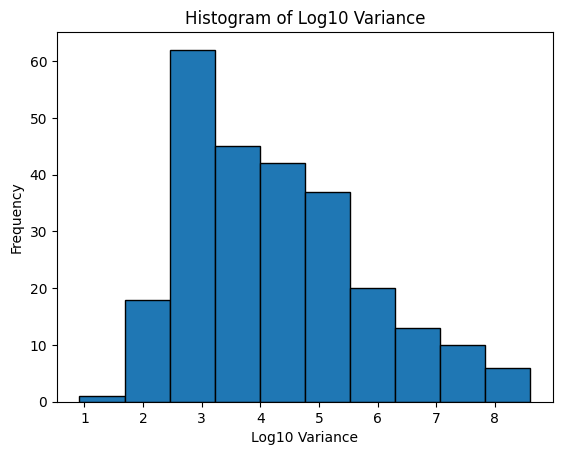

In [28]:
import matplotlib.pyplot as plt

# Extract the 'Log10 variance' column from the DataFrame
log10_variance = variance_df['Log10 Variance']

# Plot the histogram
plt.hist(log10_variance, bins=10, edgecolor='black')

# Set the labels and title
plt.xlabel('Log10 Variance')
plt.ylabel('Frequency')
plt.title('Histogram of Log10 Variance')

# Display the plot
plt.show()

To filter for genes of high variance while excluding the lower tail and maintaining the bulk of the distribution, a suitable threshold would be Log10 Variance of 2. This value effectively excludes the lower tail (the bins for Log10 Variance 1 and 2) while retaining the significant portion of the distribution that exhibits higher variance, which is important for further analysis.

#Question 2

Add 1 to the `Thymus_CD4VsCD8_CountsNormal` expression data frame and then apply a log2 transformation to the data frame.

Use this data frame to slice out the values of the **high variance genes** that you selected in Q1, and then calculate the Pearson correlation coefficient for all pairwise comparisons from this sliced data frame. Then calculate an adjacency matrix by using a 0.95 correlation threshold and by removing the diagonal values. Convert the contents of this adjacency matrix to integer values.  

Use the `seaborn` clustermap to plot the pairwise Pearson correlation values and the adjacency matrix values, using a diverging color palette (these will end up being 2 separate plots). By visually inspecting the first plot of the Pearson correlation clustermap, how many clusters of high correlation are most visually apparent in this visualization?

In [29]:
sliced_df # sanity check

,ABLIM3,ACP3,ADAM23,ADAMTS17,ADRB1,...,XIST,YEATS2-AS1,ZBTB7B,ZNF215,ZNF683
SampleID,,,,,,,,,,,
CD4_thymus_1,5.72,120.08,1797.46,294.49,41.93,...,21810.64,4.77,1139.85,2984.01,4.77
CD4_thymus_2,3.41,124.88,1510.82,44.36,46.40,...,6.14,15.70,1591.35,1903.88,7.51
CD4_thymus_3,3.54,33.94,1402.45,161.21,27.58,...,18364.01,5.30,1134.47,118.79,6.01
CD4_thymus_4,4.64,91.30,1022.88,123.02,19.34,...,18969.69,7.74,991.16,234.44,1.55
CD8_thymus_1,37.00,11.51,92.92,1615.82,604.39,...,13.16,39.47,101.14,17.27,609.33
CD8_thymus_2,51.66,5.74,28.70,1239.92,232.48,...,8.61,60.27,160.73,28.70,327.20
CD8_thymus_3,22.94,6.88,93.28,1166.04,284.44,...,13.00,29.82,66.52,15.29,148.34
CD8_thymus_4,15.45,2.57,61.78,612.66,236.83,...,2.57,82.37,87.52,332.07,254.84
CD8_thymus_5,57.45,18.02,100.26,1836.24,264.73,...,15.77,150.95,98.01,395.41,350.35


In [30]:
# Calculate log2 transform
sliced_df_log2 = np.log2(sliced_df + 1) # creates the data frame with the log2-transformed count

In [31]:
sliced_df_log2

,ABLIM3,ACP3,ADAM23,ADAMTS17,ADRB1,...,XIST,YEATS2-AS1,ZBTB7B,ZNF215,ZNF683
SampleID,,,,,,,,,,,
CD4_thymus_1,2.75,6.92,10.81,8.21,5.42,...,14.41,2.53,10.16,11.54,2.53
CD4_thymus_2,2.14,6.98,10.56,5.50,5.57,...,2.84,4.06,10.64,10.90,3.09
CD4_thymus_3,2.18,5.13,10.45,7.34,4.84,...,14.16,2.66,10.15,6.90,2.81
CD4_thymus_4,2.50,6.53,10.00,6.95,4.35,...,14.21,3.13,9.95,7.88,1.35
CD8_thymus_1,5.25,3.65,6.55,10.66,9.24,...,3.82,5.34,6.67,4.19,9.25
CD8_thymus_2,5.72,2.75,4.89,10.28,7.87,...,3.26,5.94,7.34,4.89,8.36
CD8_thymus_3,4.58,2.98,6.56,10.19,8.16,...,3.81,4.95,6.08,4.03,7.22
CD8_thymus_4,4.04,1.84,5.97,9.26,7.89,...,1.84,6.38,6.47,8.38,8.00
CD8_thymus_5,5.87,4.25,6.66,10.84,8.05,...,4.07,7.25,6.63,8.63,8.46


In [32]:
# Step 1: Import the necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

# Step 2: Slice the 'sliced_df_log2' data frame using the high variance genes selected in Q1; var threshold greater than 2. 
high_variance_genes = variance_df[variance_df['Log10 Variance'] > 2].index
sliced_df_high_variance = sliced_df_log2[high_variance_genes]

# Step 3: Calculate the Pearson correlation coefficient for all pairwise comparisons using the sliced data frame
correlation_matrix = sliced_df_high_variance.corr(method='pearson')

# Print the correlation matrix
correlation_matrix

,ABLIM3,ACP3,ADAM23,ADAMTS17,ADRB1,...,XIST,YEATS2-AS1,ZBTB7B,ZNF215,ZNF683
ABLIM3,1.00,-0.73,-0.91,0.94,0.89,...,-0.64,0.86,-0.88,-0.57,0.93
ACP3,-0.73,1.00,0.92,-0.76,-0.80,...,0.65,-0.74,0.89,0.68,-0.86
ADAM23,-0.91,0.92,1.00,-0.85,-0.89,...,0.74,-0.87,0.93,0.66,-0.94
ADAMTS17,0.94,-0.76,-0.85,1.00,0.87,...,-0.46,0.72,-0.90,-0.61,0.88
ADRB1,0.89,-0.80,-0.89,0.87,1.00,...,-0.79,0.83,-0.93,-0.59,0.98
...,...,...,...,...,...,...,...,...,...,...,...
XIST,-0.64,0.65,0.74,-0.46,-0.79,...,1.00,-0.84,0.70,0.31,-0.80
YEATS2-AS1,0.86,-0.74,-0.87,0.72,0.83,...,-0.84,1.00,-0.84,-0.33,0.89
ZBTB7B,-0.88,0.89,0.93,-0.90,-0.93,...,0.70,-0.84,1.00,0.64,-0.93
ZNF215,-0.57,0.68,0.66,-0.61,-0.59,...,0.31,-0.33,0.64,1.00,-0.59


In [33]:
import numpy as np

# Assuming 'correlation_matrix' is your correlation matrix
threshold = 0.95

# Apply correlation threshold
adjacency_matrix = np.where(np.abs(correlation_matrix) >= threshold, 1, 0)

# Remove diagonal values
np.fill_diagonal(adjacency_matrix, 0)

# Convert to integer values
adjacency_matrix = adjacency_matrix.astype(int)



In [34]:
adjacency_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

Text(0.5, 1.0, 'Pearson Correlation Clustermap')

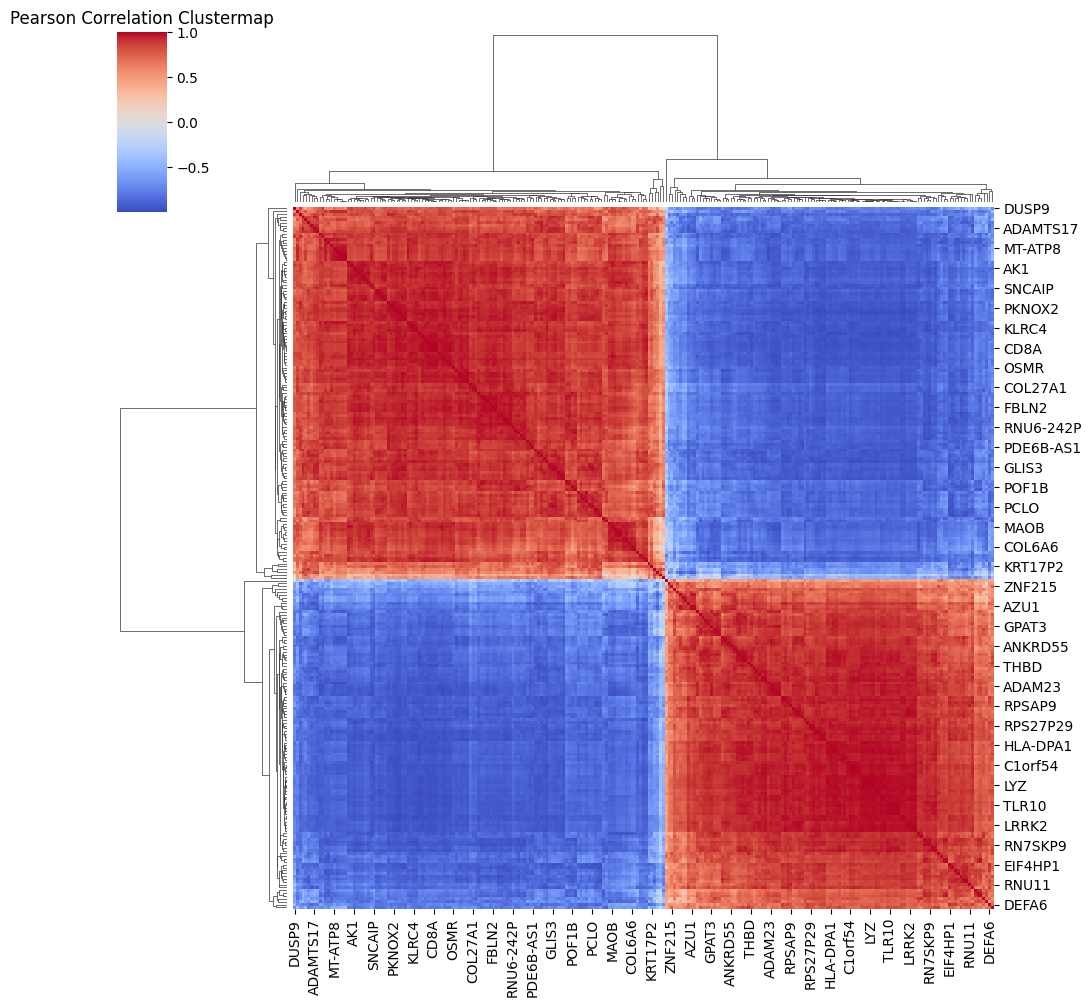

Text(0.5, 1.0, 'Adjacency Matrix Clustermap')

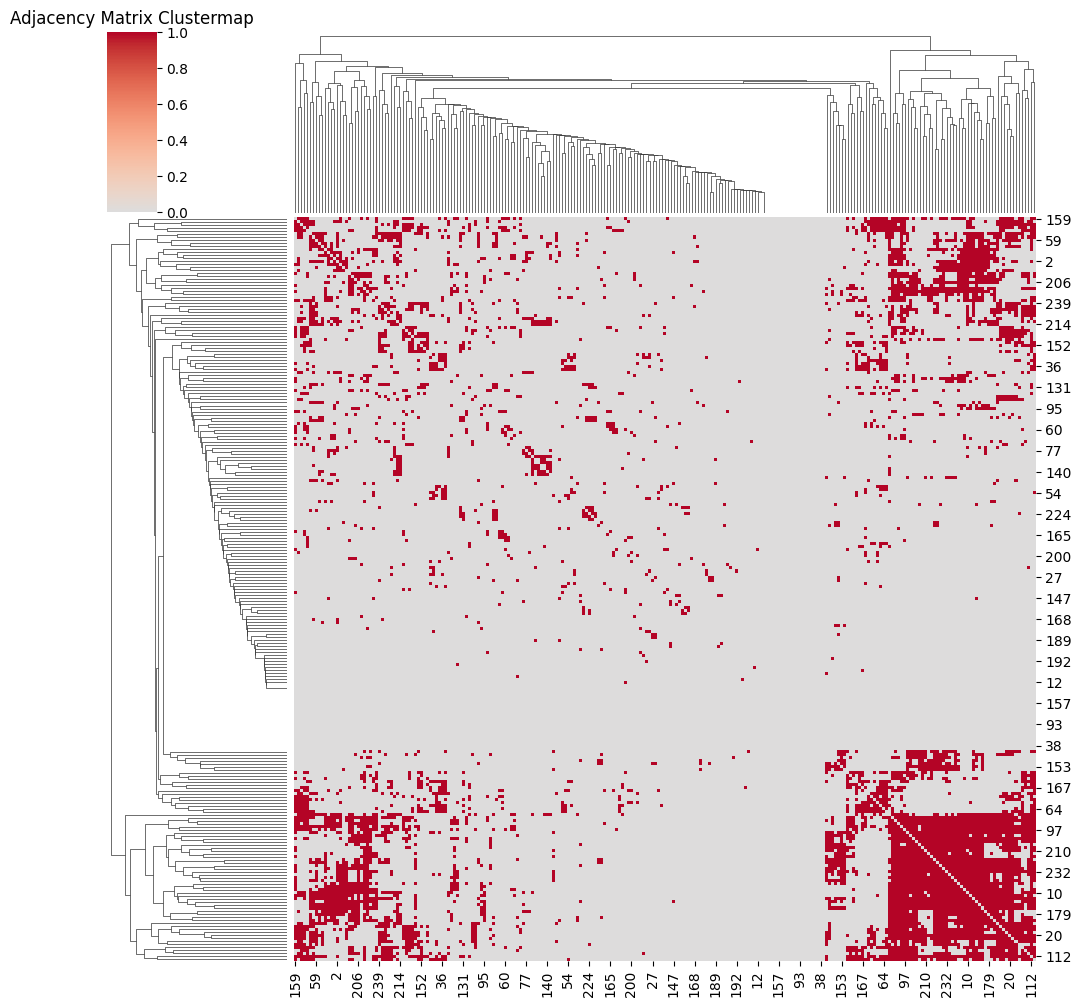

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot Pearson correlation clustermap
sns.clustermap(correlation_matrix, cmap='coolwarm', center=0)
plt.title('Pearson Correlation Clustermap')
plt.show()

# Plot adjacency matrix clustermap
sns.clustermap(adjacency_matrix, cmap='coolwarm', center=0)
plt.title('Adjacency Matrix Clustermap')
plt.show()


 ## By visually inspecting the first plot of the Pearson correlation clustermap, how many clusters of high correlation are most visually apparent in this visualization?

From the first plot of the Pearson correlation clustermap, there are two visually apparent clusters of high correlation. One cluster can be seen in the red area, which shows positive high correlation, and the other in the blue area, indicating a strong negative correlation.

## Question 3

Convert the adjacency matrix that you calculated in Q2 into a NetworkX graph. How many nodes and edges does this graph have altogether?

How many connected components (i.e. disconnected subnetworks) does this graph have?


In [38]:
import numpy as np
import networkx as nx

# Assuming adjacency_matrix is already defined, convert it to a NumPy array
adjacency_matrix_np = np.array(adjacency_matrix)

# Convert the NumPy array to a NetworkX graph
graph = nx.from_numpy_array(adjacency_matrix_np)

# Calculate number of nodes and edges
num_nodes = graph.number_of_nodes()
num_edges = graph.number_of_edges()

# Calculate number of connected components
num_components = nx.number_connected_components(graph)

print("Number of nodes:", num_nodes)
print("Number of edges:", num_edges)
print("Number of connected components:", num_components)


Number of nodes: 247
Number of edges: 3410
Number of connected components: 24


In [42]:
# The CytoscapeWidget is a widget provided by the ipycytoscape library for
# visualizing complex networks. The widget provides interactive features and
# can be displayed in a Jupyter notebook.
cyto_widget = ipycytoscape.CytoscapeWidget(247)

In [43]:
# The add_graph_from_networkx() function is used to convert the NetworkX graph
# into a format that can be used by the Cytoscape widget. This function adds
# the nodes and edges from the NetworkX graph to the Cytoscape graph.
cyto_widget.graph.add_graph_from_networkx(graph)

In [44]:
# The display() function is used to display the Cytoscape widget in the Jupyter
# notebook. The widget will display the graph and allow you to interact with it.
display(cyto_widget)

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'background-c…

# Question 4

DUSP9 is one of the genes that is differentially expressed and featured in in the Pearson Correlation Clustermap from Q2. Look up the human version of this protein in https://www.uniprot.org/, selecting the entry that is Swis-Prot-reviewed, and write down the annotated function here.

If you click on the "structure" tab on the entry, you should see reference to 3 different structures (2 from PDB and 1 from AlphaFold). Open ChimeraX, then go to **File -> Fetch By ID**. A window should pop up, which should enable you to fetch the structure of the DUSP9 PDB structure that has the higher resolution by the ID referred to in the uniprot page above (*Hint:* the resolution of this file should be less than 2 angstroms).

Once you see the structure, change the color of the structure to something other than the inital default color. **Attach a screenshot to this ipynb file ** of the visualization of the protein structure once you've changed the color of the ribbon view of the structure.

For help about ChimeraX usage, go here:
https://www.cgl.ucsf.edu/chimerax/tutorials.html

## Annotated Function of DUSP9 :  Synonyms : MKP4

Dual specificity protein phosphatase 9(DUSP9) is a protein which 

Inactivates MAP kinases. Has a specificity for the ERK family.

Annotated functions are: hydrolase activity, catalytic activity:acting on a protein(MAP kinase tyrosine phosphatase activity,), signaling(ERK1 and ERK2 cascade,JNK cascade, neg reg of MAPK cascade)

# Question 5

Use Fetch By ID again to fetch the AlphaFold structure of DUSP9 into the view.

Go to **Tools -> Structure Analysis -> Matchmaker** to get ChimeraX to calculate the superposition of two structures. Use the PDB structure as the reference structure, and make sure that the "show pairwise sequence alignment(s)" box is checked under the "alignment tab" of the Matchmaker window.

Report back the calculated RMSD values calculated for both the pruned atom pairs and all the atom pairs.

Use the sequence alignment window to select the amino acid residues that are part of the main fit, by clicking on the residues that are highlighted in light orange. Go to the molecule display tab, and visualize the selected residues with the "hydrophobic" visualization. **Attach a screenshot to this ipynb file ** of the entire set of structures with the hydrophobic visulaization of the aligned residues.

*Hint:* This tutorial has more information about superimposing structures:
https://rbvi.github.io/chimera-tutorials/presentations/modules/chimerax-comp-structures/index.html#/comparison



## RMSD between 135 pruned atom pairs is 0.615 angstroms; (across all 144 pairs: 1.162)